I have tried some more times to make results better, so results from pdf report and here can be different. But of course difference it's not huge, around 1-2%. 

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
%%capture
get_dbn_library()

In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv
import torch.nn.functional as functional
from tqdm.notebook import tqdm
from torchvision import datasets, transforms
from sklearn import metrics

from DBN import DBN

In [4]:
print(torch.cuda.is_available())
device = torch.device("cuda")

True


In [5]:
%%capture
mnist_train = tv.datasets.FashionMNIST('data/', train=True, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                         ))

mnist_test = tv.datasets.FashionMNIST("data/",
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))

In [6]:
mnist_train.data = (mnist_train.data.type(torch.FloatTensor)/255)
mnist_test.data = (mnist_test.data.type(torch.FloatTensor)/255)

In [7]:
print('train shape: ' + str(mnist_train.data.shape))
print('test shape: ' + str(mnist_test.data.shape))

train shape: torch.Size([60000, 28, 28])
test shape: torch.Size([10000, 28, 28])


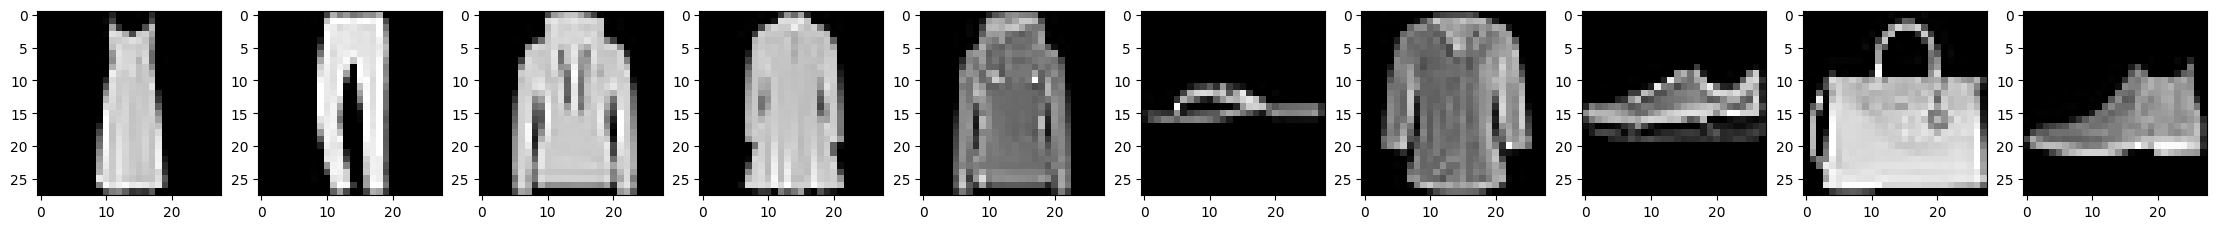

In [8]:
fig,axes = plt.subplots(1,10,figsize=(28, 28))
axes[0].imshow(mnist_test.data[13].reshape((28,28)), cmap=plt.cm.gray)
axes[1].imshow(mnist_test.data[2].reshape((28,28)), cmap=plt.cm.gray)
axes[2].imshow(mnist_test.data[74].reshape((28,28)), cmap=plt.cm.gray)
axes[3].imshow(mnist_test.data[29].reshape((28,28)), cmap=plt.cm.gray)
axes[4].imshow(mnist_test.data[54].reshape((28,28)), cmap=plt.cm.gray)
axes[5].imshow(mnist_test.data[8].reshape((28,28)), cmap=plt.cm.gray)
axes[6].imshow(mnist_test.data[4].reshape((28,28)), cmap=plt.cm.gray)
axes[7].imshow(mnist_test.data[9].reshape((28,28)), cmap=plt.cm.gray)
axes[8].imshow(mnist_test.data[30].reshape((28,28)), cmap=plt.cm.gray)
axes[9].imshow(mnist_test.data[0].reshape((28,28)), cmap=plt.cm.gray)

In [9]:
mnist_train.data = mnist_train.data.to(device)
mnist_test.data = mnist_test.data.to(device)
mnist_train.targets = mnist_train.targets.to(device)
mnist_test.targets = mnist_test.targets.to(device)

In [10]:
dbn_mnist = DBN(visible_units=28*28,
                hidden_units=[400, 500, 800],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

In [11]:
num_epochs = 50
batch_size = 125

dbn_mnist.train_static(
    mnist_train.data,
    mnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.8685     |0.0842       |314.9753   |6.2288     |
|20    |1.7430     |0.0806       |298.7238   |5.1088     |
|30    |1.7131     |0.0787       |294.4893   |5.4210     |
|40    |1.7000     |0.0766       |292.1997   |5.0362     |
|50    |1.6871     |0.0764       |285.5582   |5.0000     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0846     |0.0364       |139.4300   |2.4233     |
|20    |1.0053     |0.0358       |129.0449   |2.3439     |
|30    |0.9858     |0.0322       |126.2056   |2.1802     |
|40    |0.9773     |0.0336       |124.9268   |2.0471     |
|50    |0.9707     |0.0319       |124.0348   |1.8999     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.8440     |0.0287       |148.2542   |2.6316     |
|20    |0.7449     |0.0245       |135.6021   |2.333

In [12]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights  

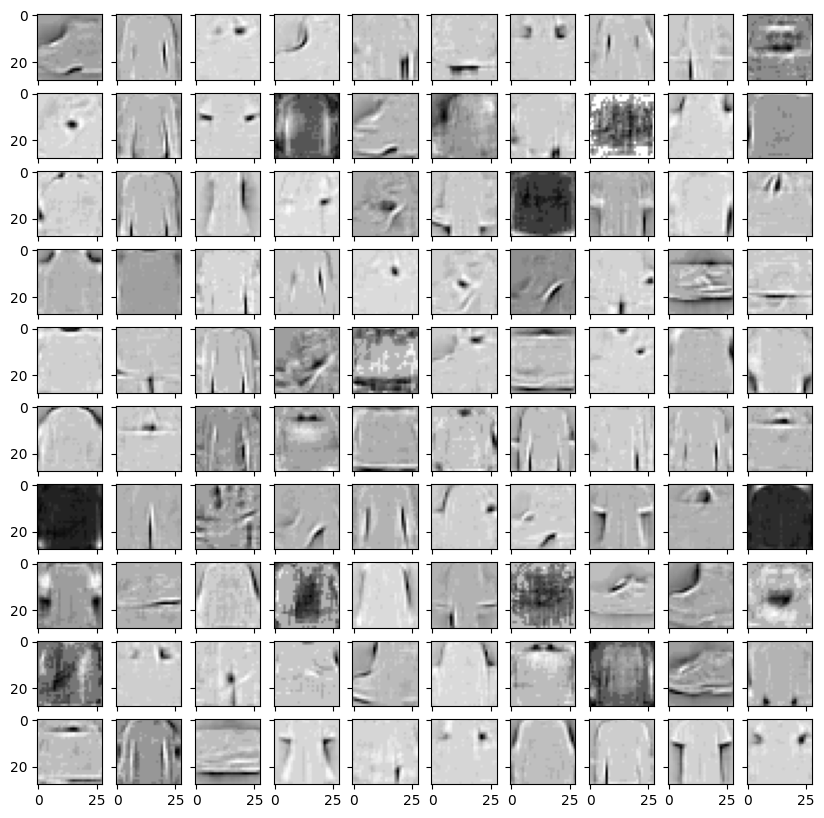

In [13]:
learned_weights_layer_1 = get_weights(dbn_mnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)

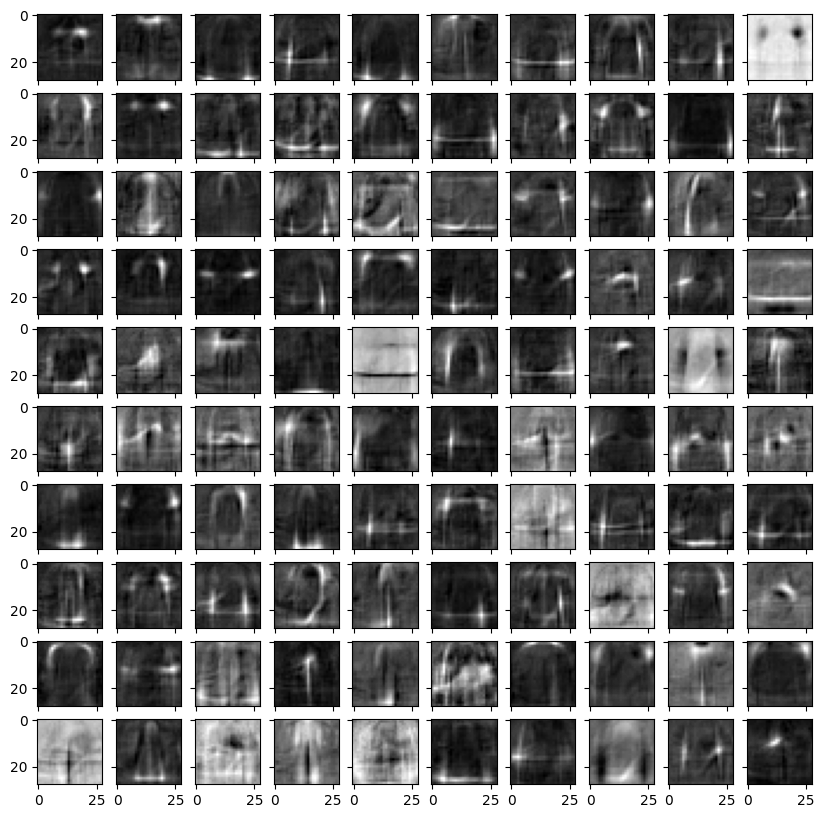

In [14]:
learned_weights_layer_1 = get_weights(dbn_mnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_mnist, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)

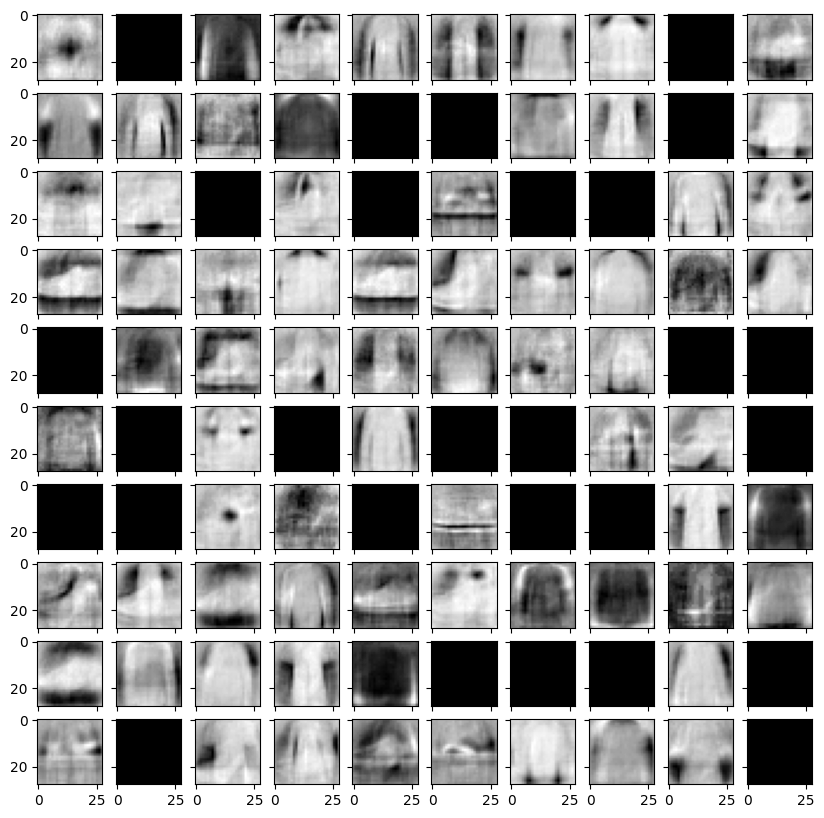

In [15]:
learned_weights_layer_1 = get_weights(dbn_mnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_mnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_mnist, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T)

In [16]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_mnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [17]:
hidden_repr_layer_1 = get_kth_layer_repr(mnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

In [18]:
def get_mask(label):  # we use this function to filter by class
  labels = mnist_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [19]:
mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_layer_1)
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_layer_2)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

In [20]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

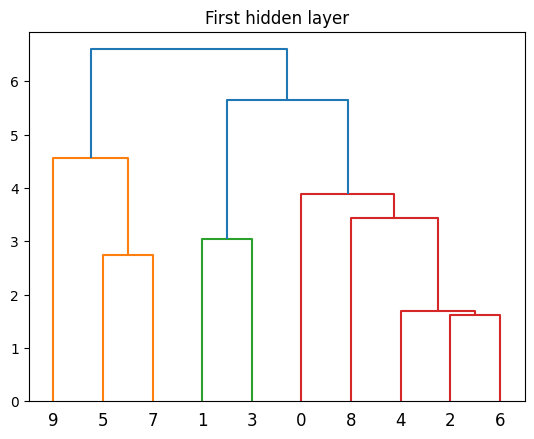

In [21]:
plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer")

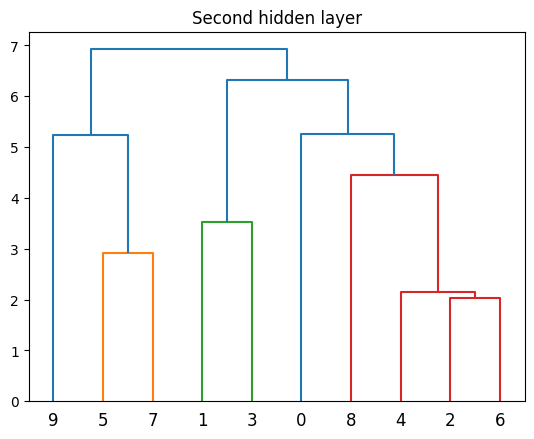

In [22]:
plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")

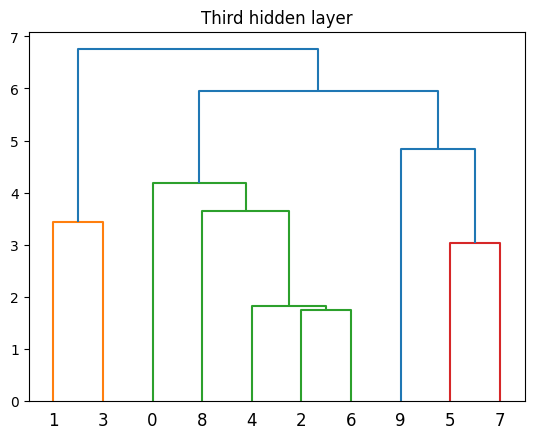

In [23]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

In [24]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

In [25]:
layer_size = dbn_mnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_mnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_mnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

In [26]:
def train_linear(linear, hidden_reprs):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  epochs = 1500

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = mnist_train.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [27]:
train_linear(linear1, hidden_repr_layer_1)

epoch :   1/1500, loss = 2.3059
epoch : 101/1500, loss = 0.9183
epoch : 201/1500, loss = 0.7217
epoch : 301/1500, loss = 0.6424
epoch : 401/1500, loss = 0.5967
epoch : 501/1500, loss = 0.5658
epoch : 601/1500, loss = 0.5431
epoch : 701/1500, loss = 0.5253
epoch : 801/1500, loss = 0.5110
epoch : 901/1500, loss = 0.4991
epoch : 1001/1500, loss = 0.4890
epoch : 1101/1500, loss = 0.4803
epoch : 1201/1500, loss = 0.4727
epoch : 1301/1500, loss = 0.4659
epoch : 1401/1500, loss = 0.4599


In [28]:
train_linear(linear2, hidden_repr_layer_2)

epoch :   1/1500, loss = 2.3345
epoch : 101/1500, loss = 0.8002
epoch : 201/1500, loss = 0.6525
epoch : 301/1500, loss = 0.5908
epoch : 401/1500, loss = 0.5540
epoch : 501/1500, loss = 0.5286
epoch : 601/1500, loss = 0.5098
epoch : 701/1500, loss = 0.4951
epoch : 801/1500, loss = 0.4833
epoch : 901/1500, loss = 0.4734
epoch : 1001/1500, loss = 0.4651
epoch : 1101/1500, loss = 0.4580
epoch : 1201/1500, loss = 0.4518
epoch : 1301/1500, loss = 0.4463
epoch : 1401/1500, loss = 0.4414


In [29]:
train_linear(linear3, hidden_repr_layer_3)

epoch :   1/1500, loss = 2.2944
epoch : 101/1500, loss = 0.8499
epoch : 201/1500, loss = 0.6748
epoch : 301/1500, loss = 0.6048
epoch : 401/1500, loss = 0.5646
epoch : 501/1500, loss = 0.5375
epoch : 601/1500, loss = 0.5176
epoch : 701/1500, loss = 0.5023
epoch : 801/1500, loss = 0.4900
epoch : 901/1500, loss = 0.4798
epoch : 1001/1500, loss = 0.4712
epoch : 1101/1500, loss = 0.4639
epoch : 1201/1500, loss = 0.4575
epoch : 1301/1500, loss = 0.4518
epoch : 1401/1500, loss = 0.4468


In [30]:
hidden_repr_layer_1_test = get_kth_layer_repr(mnist_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

In [31]:
# here we compute the predictions
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

In [32]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [33]:
compute_accuracy(predictions_test1, mnist_test.targets)

0.8324999809265137

In [34]:
compute_accuracy(predictions_test2, mnist_test.targets)

0.8381999731063843

In [35]:
compute_accuracy(predictions_test3, mnist_test.targets)

0.8337000012397766

START FEED-FORWARD MODEL

In [36]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [37]:
ffnn = Feedforward(400, 500, 800).to(device)

In [38]:
def train(network, input, epochs=1500):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    targets = mnist_train.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [39]:
train(ffnn, mnist_train.data.reshape((60000, 784)), epochs=1500)

epoch :   1/1500, loss = 2.3047
epoch : 101/1500, loss = 1.4639
epoch : 201/1500, loss = 0.9363
epoch : 301/1500, loss = 0.7750
epoch : 401/1500, loss = 0.6808
epoch : 501/1500, loss = 0.6183
epoch : 601/1500, loss = 0.5727
epoch : 701/1500, loss = 0.5535
epoch : 801/1500, loss = 0.5242
epoch : 901/1500, loss = 0.5031
epoch : 1001/1500, loss = 0.4879
epoch : 1101/1500, loss = 0.4747
epoch : 1201/1500, loss = 0.4624
epoch : 1301/1500, loss = 0.4680
epoch : 1401/1500, loss = 0.4410


In [40]:
predictions_ffnn = ffnn(mnist_test.data.reshape((10000, 784)))

In [41]:
compute_accuracy(predictions_ffnn, mnist_test.targets)

0.8319000005722046

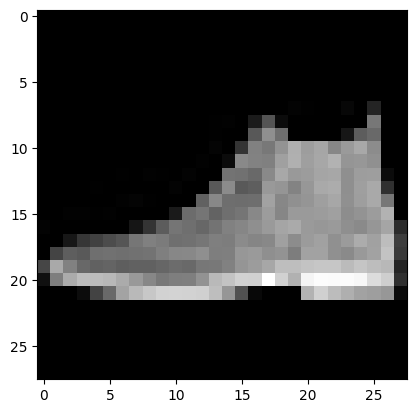

In [42]:
__ = plt.imshow(mnist_test.data[0].reshape(28, 28).to("cpu"), cmap="gray")

In [43]:
def inject_noise(mnist_data, noise_level):
  
  ### TASK: create a very simple function that adds some Gaussian noise (see torch.randn function) to the MNIST data
  noise = torch.randn(mnist_data.shape,device = device)*noise_level
  return noise + mnist_data

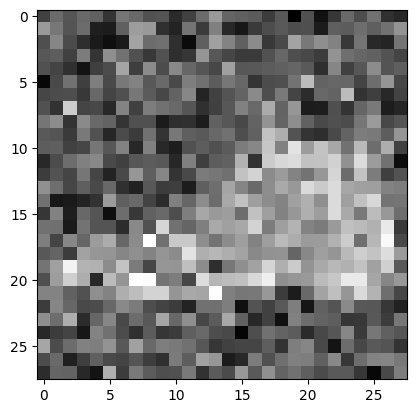

In [44]:
noise_level = 0.3
mnist_test_with_noise = inject_noise(mnist_test.data, noise_level)
__ = plt.imshow(mnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

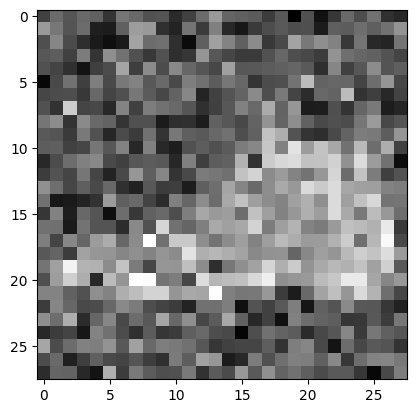

In [45]:
noise_level = 0.3
mnist_test_with_noise2 = inject_noise(mnist_test.data, noise_level)
__ = plt.imshow(mnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

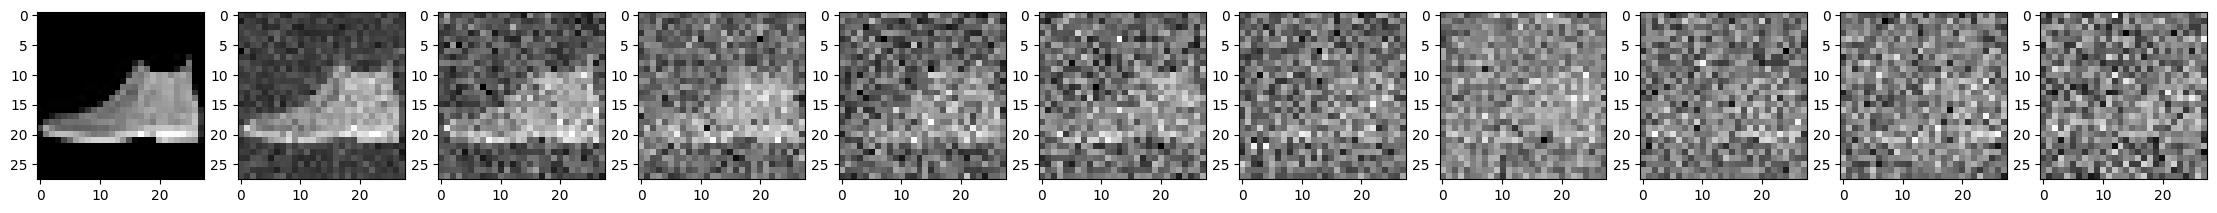

In [46]:
noise_level = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
fig,axes = plt.subplots(1,11,figsize=(28,28))
for noise in range(len(noise_level)):
  mnist_test_with_noise = inject_noise(mnist_test.data, noise_level[noise])
  axes[noise].imshow(mnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap=plt.cm.gray)

In [47]:
def get_accuracy_values_at_noise_level(noise_level):

  mnist_test_with_noise = inject_noise(mnist_test.data, noise_level)  # first, let's create noisy test images
  
  hidden_repr_layer_1_noisy = get_kth_layer_repr(mnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)
  
  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)
  
  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, mnist_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, mnist_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, mnist_test.targets)
  
  ### TASK: repeat a similar process for the feed-forward model (NB: make sure you reshape the input data appropriately!)
  ffnn_noise = ffnn(mnist_test_with_noise.reshape((10000, 784)))
  accuracy_ffnn = compute_accuracy(ffnn_noise, mnist_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

In [48]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.803
Accuracy of H2 read-out: 0.820
Accuracy of H3 read-out: 0.822
Accuracy of FF network : 0.792


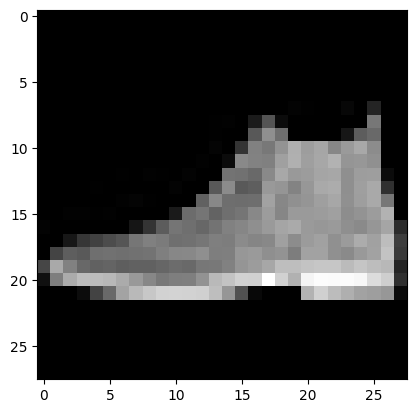

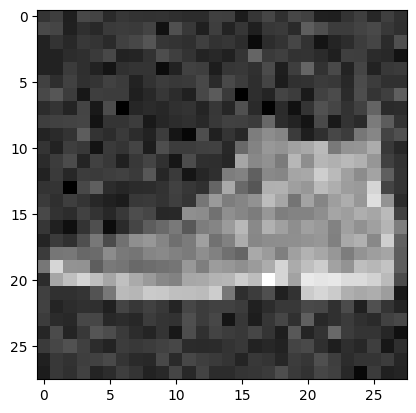

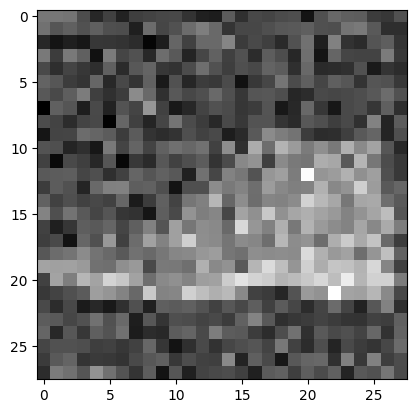

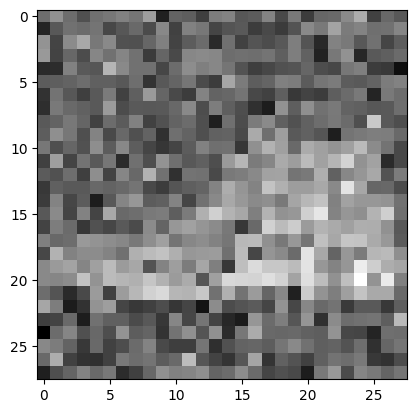

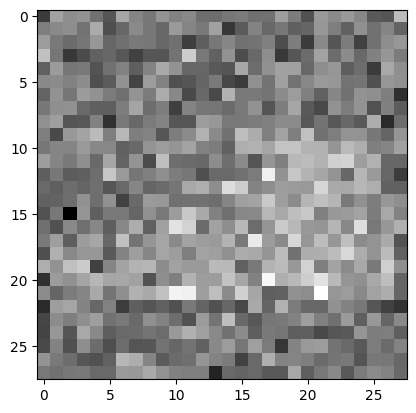

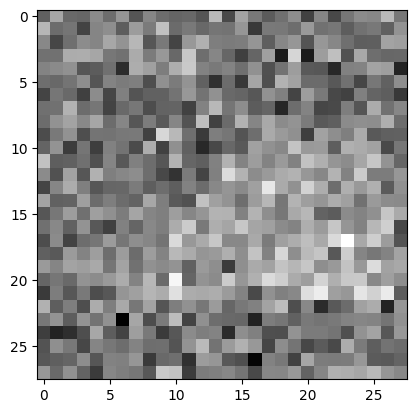

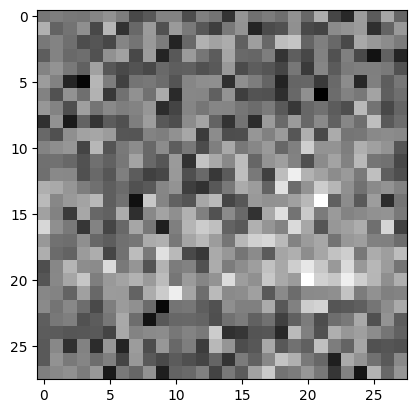

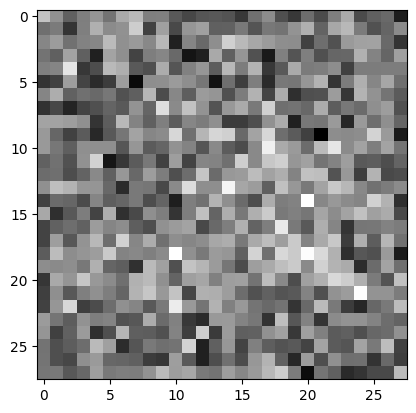

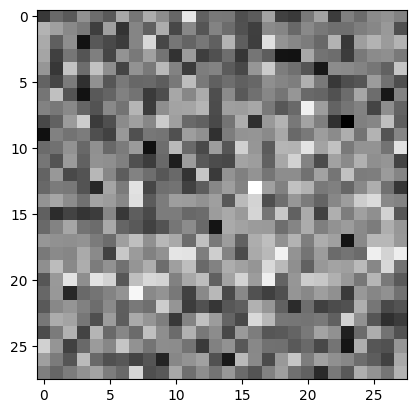

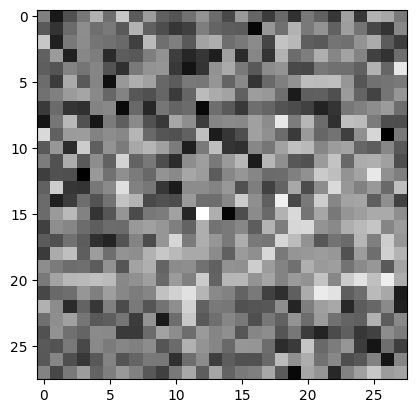

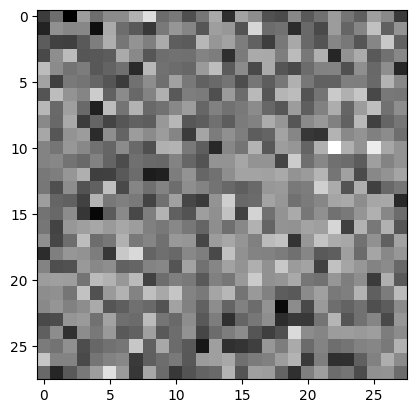

In [49]:
noise_level = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for noise in noise_level:
  fig, axes = plt.subplots(1,1)
  mnist_test_with_noise = inject_noise(mnist_test.data, noise)
  plt.imshow(mnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

In [50]:
noise_level = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for noise in noise_level:
    acc = get_accuracy_values_at_noise_level(noise);
    print('Noise '+str(noise)+':')
    print("Accuracy of H3 read-out: %.3f" % acc[2])
    print("Accuracy of FF network : %.3f" % acc[3] + '\n')
    

Noise 0:
Accuracy of H3 read-out: 0.834
Accuracy of FF network : 0.832

Noise 0.1:
Accuracy of H3 read-out: 0.833
Accuracy of FF network : 0.827

Noise 0.2:
Accuracy of H3 read-out: 0.830
Accuracy of FF network : 0.814

Noise 0.3:
Accuracy of H3 read-out: 0.822
Accuracy of FF network : 0.793

Noise 0.4:
Accuracy of H3 read-out: 0.809
Accuracy of FF network : 0.763

Noise 0.5:
Accuracy of H3 read-out: 0.787
Accuracy of FF network : 0.731

Noise 0.6:
Accuracy of H3 read-out: 0.761
Accuracy of FF network : 0.690

Noise 0.7:
Accuracy of H3 read-out: 0.733
Accuracy of FF network : 0.656

Noise 0.8:
Accuracy of H3 read-out: 0.701
Accuracy of FF network : 0.613

Noise 0.9:
Accuracy of H3 read-out: 0.667
Accuracy of FF network : 0.581

Noise 1:
Accuracy of H3 read-out: 0.630
Accuracy of FF network : 0.560



In [51]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

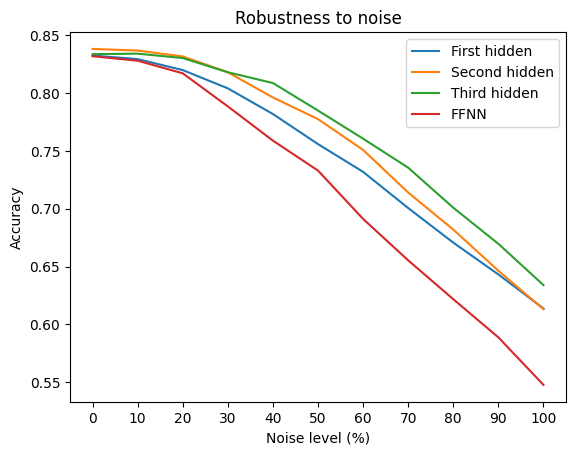

In [52]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plot_noise_robustness_curves(noise_levels)

In [68]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [69]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_mnist = dbn_mnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [70]:
dbn_with_readout = DBNWithReadOut(dbn_mnist, [linear1, linear2, linear3], readout_level=2)

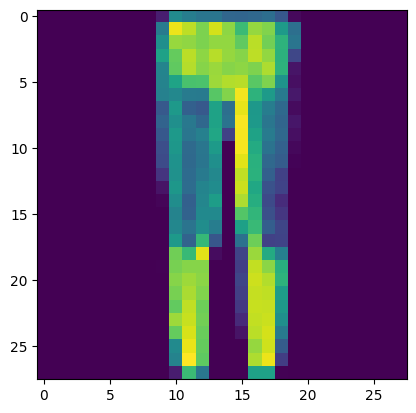

In [71]:
test_sample_idx = 3
test_image = mnist_test.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

In [72]:
attacked_model1 = ffnn

In [73]:
test_image.requires_grad_()
model_outputs = attacked_model1(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the FFNN model for this clean sample is {prediction}.")

The prediction of the FFNN model for this clean sample is 1.


In [74]:
attacked_model2 = dbn_with_readout

In [75]:
test_image.requires_grad_()
model_outputs = attacked_model2(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the DBN with readout for this clean sample is {prediction}.")

The prediction of the DBN with readout for this clean sample is 1.


In [76]:
attacked_model = dbn_with_readout

In [77]:
attacked_model = dbn_with_readout

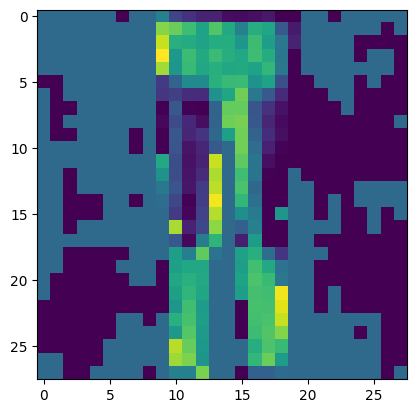

In [78]:
epsilon = 0.3  # define strenght of the attack
test_image_label = mnist_test.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss

perturbed_image = fgsm_attack(test_image, epsilon, image_grad)
perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [79]:
model_outputs1 = attacked_model1(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the FFNN for the perturbed sample is {torch.argmax(model_outputs1)}.")
model_outputs2 = attacked_model2(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the DBN with readout for the perturbed sample is {torch.argmax(model_outputs2)}.")

The prediction of the FFNN for the perturbed sample is 3.
The prediction of the DBN with readout for the perturbed sample is 6.


In [80]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack
        
        output = model.forward(data)

        init_pred = torch.argmax(output)
        
        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [81]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/', train=False, download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

In [82]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 25.64%



In [83]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1, 
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 39.08%



As we can see for just epsilon=0.1, we have accuracy of FFNN almost 37% and DBN 78%. It's a huge difference. And let's check epsilon=0.2.

In [84]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 1.33%



In [85]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.2, 
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 14.05%



  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



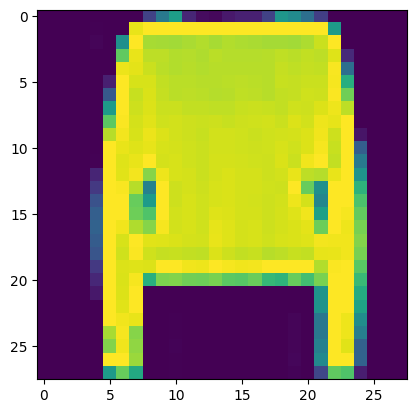


Here's a perturbed sample:



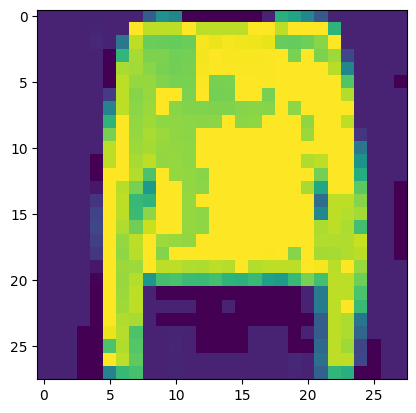


Here's what a 1-steps reconstructed sample looks like:



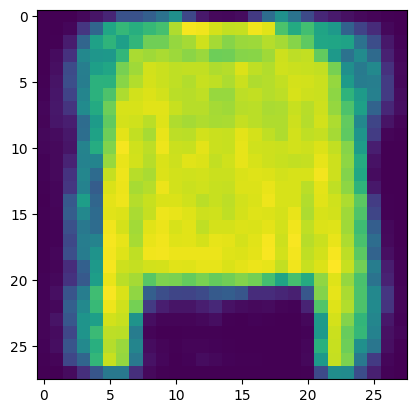


Epsilon: 0.1
Test Accuracy: 35.76%



In [86]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1, 
                                      num_steps=1)

  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



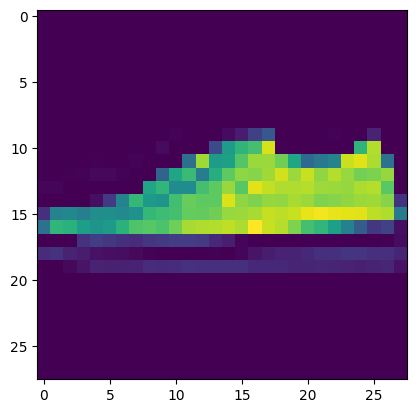


Here's a perturbed sample:



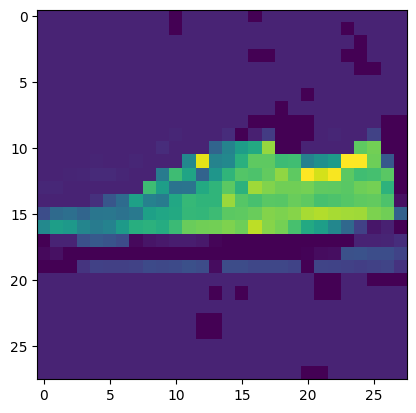


Here's what a 2-steps reconstructed sample looks like:



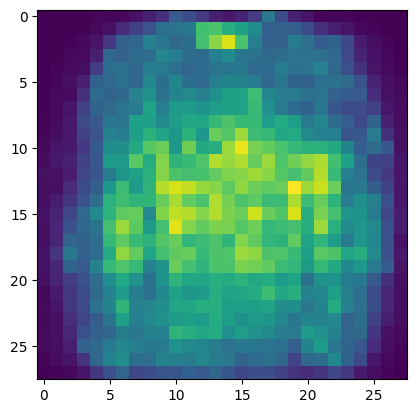


Epsilon: 0.1
Test Accuracy: 35.08%



In [87]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1, 
                                      num_steps=2)

In [88]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [89]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

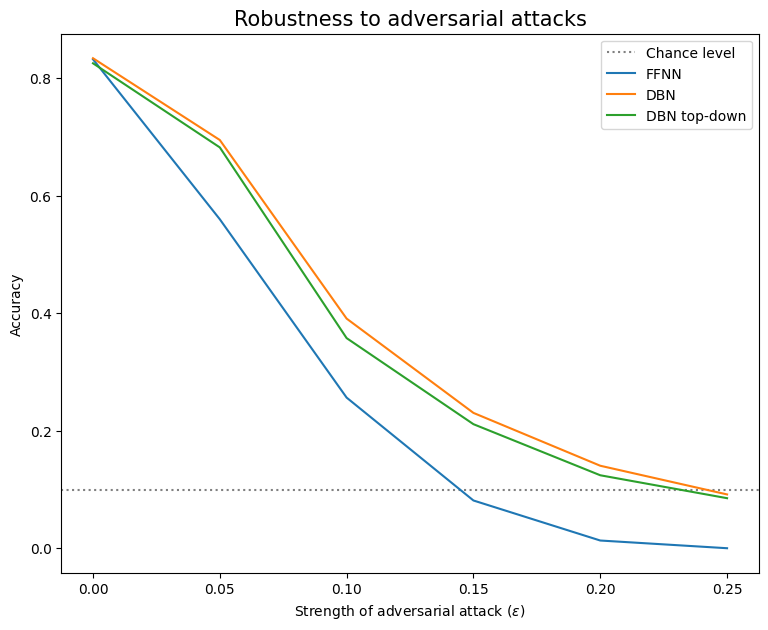

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

In [91]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)
accuracies_dbn_2 = test_epsilon_values_effect(dbn_with_readout, n_steps=2)
accuracies_dbn_3 = test_epsilon_values_effect(dbn_with_readout, n_steps=3)
accuracies_dbn_4 = test_epsilon_values_effect(dbn_with_readout, n_steps=4)
accuracies_dbn_5 = test_epsilon_values_effect(dbn_with_readout, n_steps=5)


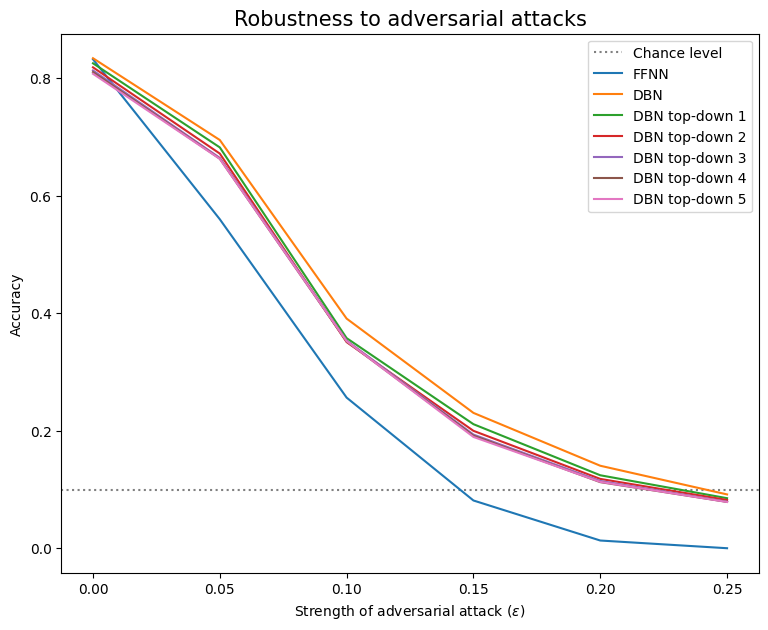

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.plot(epsilon_values, accuracies_dbn_2)
__ = ax.plot(epsilon_values, accuracies_dbn_3)
__ = ax.plot(epsilon_values, accuracies_dbn_4)
__ = ax.plot(epsilon_values, accuracies_dbn_5)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down 1", "DBN top-down 2", "DBN top-down 3", "DBN top-down 4", "DBN top-down 5"])

In [93]:
epsilon_values = [0, 0.05, 0.10]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [94]:
%%capture
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)
accuracies_dbn_2 = test_epsilon_values_effect(dbn_with_readout, n_steps=2)
accuracies_dbn_3 = test_epsilon_values_effect(dbn_with_readout, n_steps=3)
accuracies_dbn_4 = test_epsilon_values_effect(dbn_with_readout, n_steps=4)
accuracies_dbn_5 = test_epsilon_values_effect(dbn_with_readout, n_steps=5)


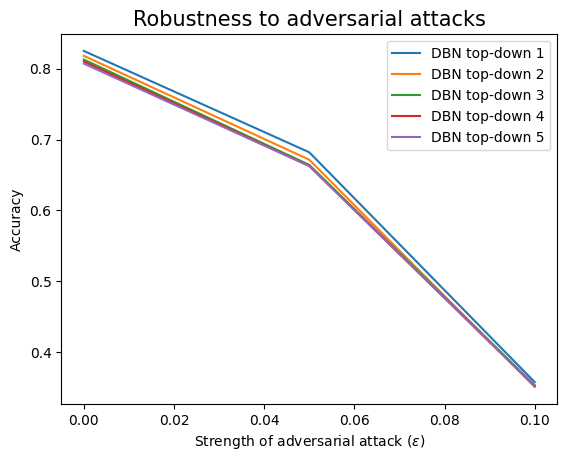

In [95]:
fig, ax = plt.subplots(1, 1, sharey=True)

__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.plot(epsilon_values, accuracies_dbn_2)
__ = ax.plot(epsilon_values, accuracies_dbn_3)
__ = ax.plot(epsilon_values, accuracies_dbn_4)
__ = ax.plot(epsilon_values, accuracies_dbn_5)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["DBN top-down 1", "DBN top-down 2", "DBN top-down 3", "DBN top-down 4", "DBN top-down 5"])

In [96]:
epsilon_values = [0.15,0.16]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [97]:
%%capture
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)
accuracies_dbn_2 = test_epsilon_values_effect(dbn_with_readout, n_steps=2)
accuracies_dbn_3 = test_epsilon_values_effect(dbn_with_readout, n_steps=3)
accuracies_dbn_4 = test_epsilon_values_effect(dbn_with_readout, n_steps=4)
accuracies_dbn_5 = test_epsilon_values_effect(dbn_with_readout, n_steps=5)


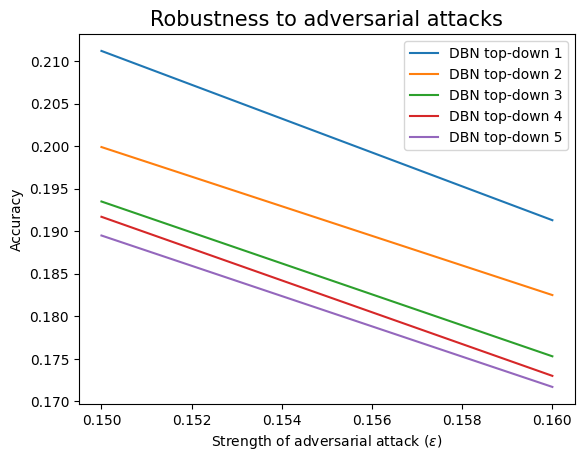

In [98]:
fig, ax = plt.subplots(1, 1, sharey=True)

__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.plot(epsilon_values, accuracies_dbn_2)
__ = ax.plot(epsilon_values, accuracies_dbn_3)
__ = ax.plot(epsilon_values, accuracies_dbn_4)
__ = ax.plot(epsilon_values, accuracies_dbn_5)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["DBN top-down 1", "DBN top-down 2", "DBN top-down 3", "DBN top-down 4", "DBN top-down 5"])

In [99]:
epsilon_values = [0.25,0.26]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [100]:
%%capture
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)
accuracies_dbn_2 = test_epsilon_values_effect(dbn_with_readout, n_steps=2)
accuracies_dbn_3 = test_epsilon_values_effect(dbn_with_readout, n_steps=3)
accuracies_dbn_4 = test_epsilon_values_effect(dbn_with_readout, n_steps=4)
accuracies_dbn_5 = test_epsilon_values_effect(dbn_with_readout, n_steps=5)


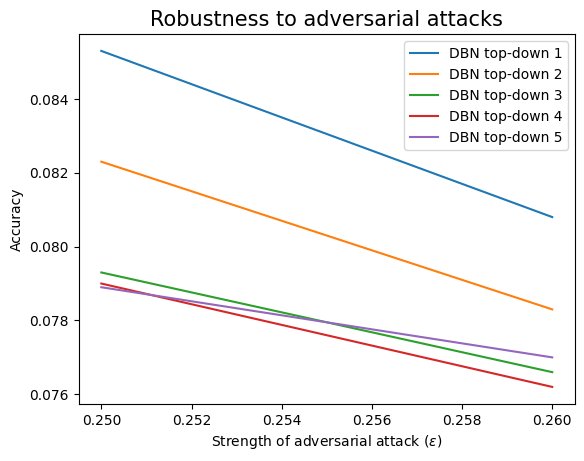

In [101]:
fig, ax = plt.subplots(1, 1, sharey=True)

__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.plot(epsilon_values, accuracies_dbn_2)
__ = ax.plot(epsilon_values, accuracies_dbn_3)
__ = ax.plot(epsilon_values, accuracies_dbn_4)
__ = ax.plot(epsilon_values, accuracies_dbn_5)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["DBN top-down 1", "DBN top-down 2", "DBN top-down 3", "DBN top-down 4", "DBN top-down 5"])